In [1]:
import ee
import geemap
import pprint as pp
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn as sns

ee.Authenticate()
ee.Initialize(project='jayathesis0811')

In [2]:
north_korea_coords = [[[124.13253718384772, 40.21335053920326],
                       [129.949853918996, 43.061730142931324],
                       [130.78322983865831, 42.22804007650052],
                       [128.2987669179184, 38.5948400683505],
                       [125.31524149369977, 37.69040330384843]]]

north_korea_geometry1 = ee.Geometry.Polygon(north_korea_coords)

KyoHwaSo_coords = [[[129.8634297005607, 42.893827126434914],
                    [130.51078146306347, 42.438049492565],
                    [129.67576441706638, 41.06180325052066],
                    [128.7824903707054, 41.987391837758274]]]

KyoHwaSo = ee.Geometry.Polygon(KyoHwaSo_coords)

In [3]:
#import prison coordinate file
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

file_path = '/content/drive/My Drive/North Korean Prison Locations.csv'

df = pd.read_csv(file_path)

print(df)

Mounted at /content/drive
   North Korea Prison Name    Latitude   Longitude
0                   Camp 22  42.700102  129.906389
1             Chongori Camp  42.303614  129.767123
2              Hwasong Camp  41.366393  129.355136
3                 Hyanghari  41.240562  126.677018
4              Hamhung Camp  40.359022  127.533952
5                Yodok Camp  39.830609  126.850331
6              Kaechon Camp  39.783961  125.935413
7    Kaechon Camp (2nd loc)  39.608100  126.055459
8             Pukchang Camp  39.587432  126.090664
9             Kangdong Camp  39.098996  126.154565
10            Sinuijiu Camp  40.258569  124.389026


In [4]:
# Creating an empty Earth Engine feature collection
features = []

for i, (_, row) in enumerate(df.iterrows(), start=1):
    lat, lon = row['Latitude'], row['Longitude']

    point = ee.Geometry.Point(lon, lat)

    feature = ee.Feature(point, {'index': i})

    features.append(feature)

feature_collection = ee.FeatureCollection(features)

Map = geemap.Map()
Map.setCenter(129.5, 42.0, 10)
Map.addLayer(KyoHwaSo, {}, 'region')
Map.addLayer(feature_collection, {'color': 'red'}, 'Markers')
Map.addLayerControl()
Map

Map(center=[42.0, 129.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [5]:
# Land classification and masking
dataset = ee.ImageCollection('COPERNICUS/Landcover/100m/Proba-V-C3/Global')
classification = dataset.select('discrete_classification').min()

mask_shrub = classification.eq(20)
mask_hveg = classification.eq(30)
mask_cveg = classification.eq(40)
mask_bare = classification.eq(60)
mask_moss = classification.eq(100)
mask_forest = classification.eq(111)
mask_forest1 = classification.eq(112)
mask_forest2 = classification.eq(113)
mask_forest3 = classification.eq(114)
mask_forest4 = classification.eq(115)
mask_forest5 = classification.eq(116)
mask_forest6 = classification.eq(121)
mask_forest7 = classification.eq(122)
mask_forest8 = classification.eq(123)
mask_forest9 = classification.eq(124)
mask_forest10 = classification.eq(125)
mask_forest11 = classification.eq(126)
mask_all = mask_shrub.Or(mask_hveg).Or(mask_cveg).Or(mask_bare)

# Loading the L8 image collection, filtering by bounds, date, and cloud cover.
korea = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
    .filterBounds(north_korea_geometry1) \
    .filterDate('2019-01-01', '2023-12-31') \
    .filter(ee.Filter.lt('CLOUD_COVER', 1)) \
    .min()

landsat_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10']
landsat = korea.select(landsat_bands)

# Loading air pollution datasets and calculate mean for date range.
UV_Aerosol = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_AER_AI") \
    .filterDate("2019-01-01", "2023-12-31") \
    .select('absorbing_aerosol_index') \
    .mean()

CO = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_CO") \
    .filterDate("2019-01-01", "2023-12-31") \
    .select('CO_column_number_density') \
    .mean()

NO = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterDate("2019-01-01", "2023-12-31") \
    .select('tropospheric_NO2_column_number_density') \
    .mean()

SO = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_SO2") \
    .filterDate("2019-01-01", "2023-12-31") \
    .select('SO2_column_number_density') \
    .mean()

elevation = ee.Image("CGIAR/SRTM90_V4").select('elevation')


# target scale and projection
target_scale = 100
target_crs = UV_Aerosol.projection()

landsat_resampled = landsat.resample('bilinear').reproject(crs=target_crs, scale=target_scale)
UV_Aerosol_resampled = UV_Aerosol.resample('bilinear').reproject(crs=target_crs, scale=target_scale)
CO_resampled = CO.resample('bilinear').reproject(crs=target_crs, scale=target_scale)
NO_resampled = NO.resample('bilinear').reproject(crs=target_crs, scale=target_scale)
SO_resampled = SO.resample('bilinear').reproject(crs=target_crs, scale=target_scale)
elevation_resampled = elevation.resample('bilinear').reproject(crs=target_crs, scale=target_scale)

# mask each layer
landsat_masked = landsat_resampled.updateMask(mask_all)
UV_Aerosol_masked = UV_Aerosol_resampled.updateMask(mask_all)
CO_masked = CO_resampled.updateMask(mask_all)
NO_masked = NO_resampled.updateMask(mask_all)
SO_masked = SO_resampled.updateMask(mask_all)
elevation_masked = elevation_resampled.updateMask(mask_all)

# Combining masked layers into a stacked image
stacked_image = landsat_masked \
    .addBands(UV_Aerosol_masked) \
    .addBands(CO_masked) \
    .addBands(NO_masked) \
    .addBands(SO_masked) \
    .addBands(elevation_masked)

vis_params = {
    'UV_Aerosol': {'min': 0, 'max': 1, 'palette': ['blue', 'purple']},
    'CO': {'min': 0, 'max': 0.05, 'palette': ['green', 'yellow', 'red']},
    'NO': {'min': 0, 'max': 0.0002, 'palette': ['blue', 'green', 'red']},
    'SO': {'min': 0, 'max': 0.0001, 'palette': ['yellow', 'orange', 'red']},
    'elevation': {'min': 0, 'max': 3000, 'palette': ['blue', 'green', 'brown']}
}

stack_vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3, 'gamma': 1.4}


m = geemap.Map()
m.setCenter(127.5, 40, 6)
m.addLayer(elevation_masked.clip(north_korea_geometry1), vis_params['elevation'], 'Elevation')
m.addLayer(stacked_image.clip(north_korea_geometry1), stack_vis_params, 'Stacked Image')
m.addLayer(feature_collection, {'color': 'red'}, 'Markers')
m.addLayerControl()
m


Map(center=[40, 127.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

In [6]:
drive_folder_path = '/content/drive/My Drive/Heatmaps_Project/'

In [7]:
#k-means clustering
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'absorbing_aerosol_index', 'CO_column_number_density', 'tropospheric_NO2_column_number_density', 'SO2_column_number_density', 'elevation']

training = stacked_image.select(bands).sample(
    region=north_korea_geometry1,
    scale=100,  #matched to scale of layers in image
    numPixels=5000,
    seed=1,  # allows for reproducibility
    tileScale=4  # used for large regions to manage memory
)

trainedKMeans = ee.Clusterer.wekaKMeans(nClusters=10000).train(training)

result = stacked_image.cluster(trainedKMeans).clip(north_korea_geometry1)

Map = geemap.Map()
Map.setCenter(127.5, 40.0, 6)
Map.addLayer(result.randomVisualizer(), {}, 'Clusters')
Map.addLayer(feature_collection, {'color': 'red'}, 'Markers')
Map.addLayerControl()
Map


Map(center=[40.0, 127.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

Clusters for Camp 22 (Location: 42.700102, 129.906389): {'1053': 31.058823529411768, '109': 192.88627450980394, '1158': 118.63921568627451, '530': 263.24313725490197, '61': 540.6549019607843, '839': 3176.807843137254, '900': 21}
Clusters for KyoHWaSo Camp 12 (Location: 42.303614, 129.767123): {'15': 800.9411764705882, '29': 136.99607843137255, '758': 1, '969': 417.3764705882353}
Clusters for Hwasong Camp (Location: 41.366393, 129.355136): {'101': 5, '744': 437.03137254901964}
Clusters for Hyanghari (Location: 41.240562, 126.677018): {'1005': 20.145098039215686, '1115': 2, '141': 181.96470588235292, '165': 107.29803921568629, '25': 1.392156862745098}
Clusters for Hamhung Camp (Location: 40.359022, 127.533952): {'1027': 15.24705882352941, '130': 1.9647058823529413, '201': 3.0392156862745097, '636': 382.60392156862747}
Clusters for Yodok Camp (Location: 39.830609, 126.850331): {}
Clusters for Kaechon Camp (Location: 39.783961, 125.935413): {'1178': 2040.7568627450983, '1181': 1529.8823529

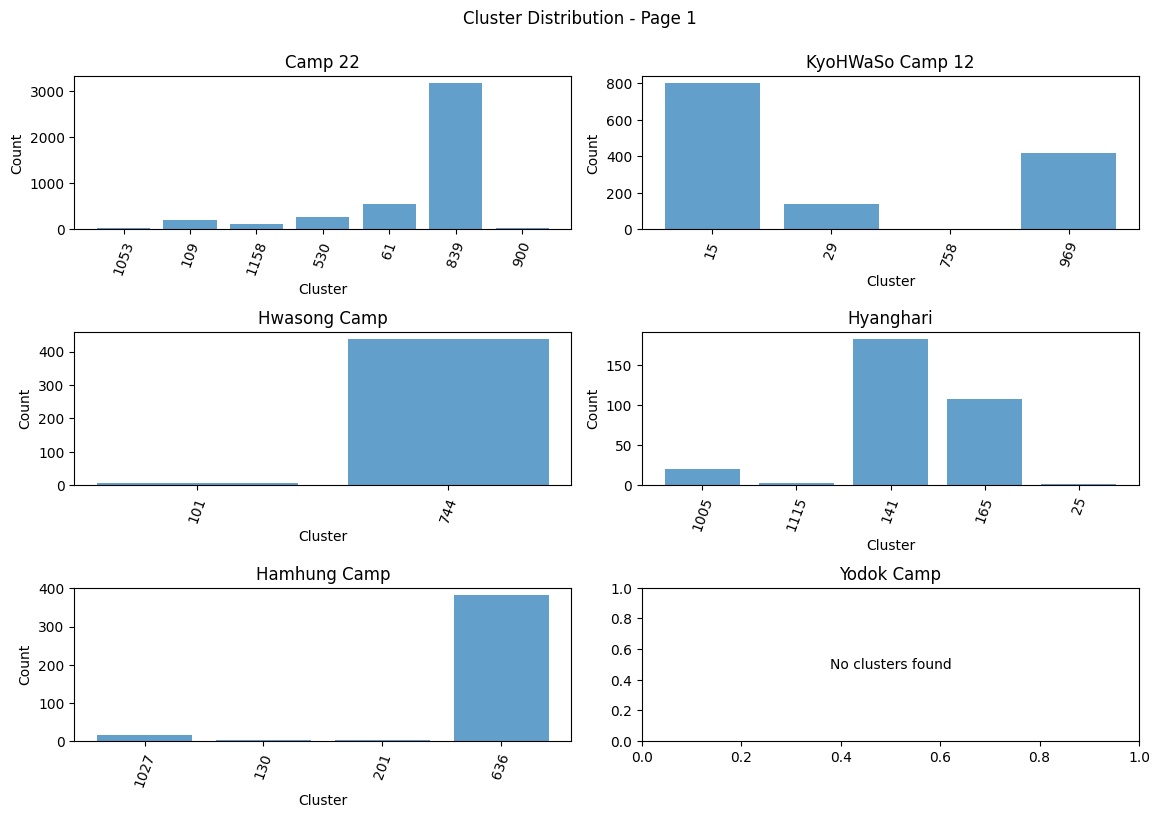

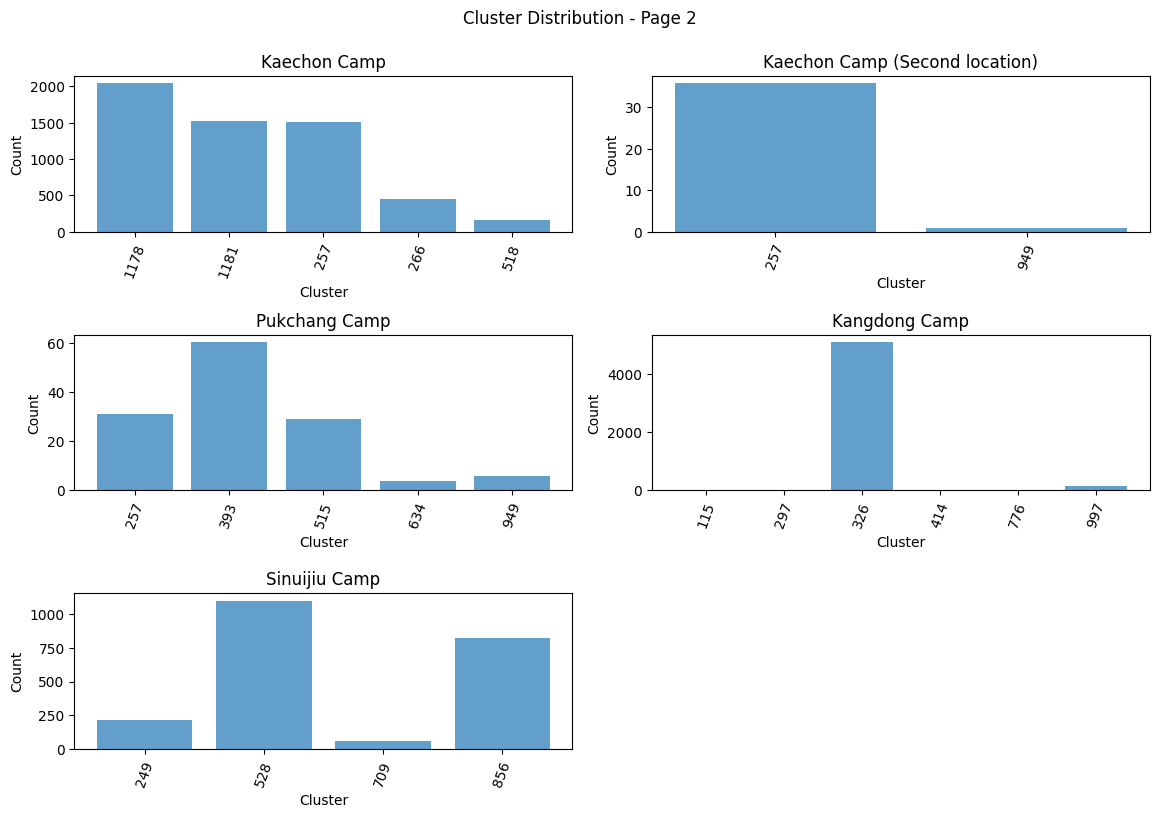

In [8]:
# Extract cluster counts and plot histograms
def extract_cluster_counts(image, locations, radius):
    cluster_counts = []
    for location in locations:
        marker_geom = ee.Geometry.Point([location['Longitude'], location['Latitude']])

        region = marker_geom.buffer(radius)

        clusters = image.reduceRegion(
            reducer=ee.Reducer.frequencyHistogram(),
            geometry=region,
            scale=100,
            maxPixels=1e13
        ).get('cluster').getInfo()

        print(f"Clusters for {location['Name']} (Location: {location['Latitude']}, {location['Longitude']}): {clusters}")

        cluster_counts.append(clusters)

    return cluster_counts

locations = [
    {'Latitude': 42.700102, 'Longitude': 129.906389, 'Name': 'Camp 22'},
    {'Latitude': 42.303614, 'Longitude': 129.767123, 'Name': 'KyoHWaSo Camp 12'},
    {'Latitude': 41.366393, 'Longitude': 129.355136, 'Name': 'Hwasong Camp'},
    {'Latitude': 41.240562, 'Longitude': 126.677018, 'Name': 'Hyanghari'},
    {'Latitude': 40.359022, 'Longitude': 127.533952, 'Name': 'Hamhung Camp'},
    {'Latitude': 39.830609, 'Longitude': 126.850331, 'Name': 'Yodok Camp'},
    {'Latitude': 39.783961, 'Longitude': 125.935413, 'Name': 'Kaechon Camp'},
    {'Latitude': 39.608100, 'Longitude': 126.055459, 'Name': 'Kaechon Camp (Second location)'},
    {'Latitude': 39.587432, 'Longitude': 126.090664, 'Name': 'Pukchang Camp'},
    {'Latitude': 39.098996, 'Longitude': 126.154565, 'Name': 'Kangdong Camp'},
    {'Latitude': 40.258569, 'Longitude': 124.389026, 'Name': 'Sinuijiu Camp'}
]

radius = 5000  # 5km

cluster_counts = extract_cluster_counts(result, locations, radius)

def plot_histograms(cluster_counts, locations):
    rows_page1, cols_page1 = 3, 2
    rows_page2, cols_page2 = 3, 2

    fig1, axs1 = plt.subplots(rows_page1, cols_page1, figsize=(11.7, 8.3))
    fig1.suptitle('Cluster Distribution - Page 1')

    for i in range(6):
        clusters = cluster_counts[i]
        location_name = locations[i]['Name']
        ax = axs1[i // cols_page1, i % cols_page1]
        if clusters:
            data = {'Cluster': list(clusters.keys()), 'Count': list(clusters.values())}
            df = pd.DataFrame(data)
            df = df.sort_values(by='Cluster')

            ax.bar(df['Cluster'], df['Count'], alpha=0.7)
            ax.set_xlabel('Cluster')
            ax.set_ylabel('Count')
            ax.set_title(location_name)
            ax.tick_params(axis='x', rotation=70)
        else:
            ax.text(0.5, 0.5, 'No clusters found', horizontalalignment='center', verticalalignment='center')
            ax.set_title(location_name)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(drive_folder_path + 'Cluster_Distribution_Page1.png', dpi=300)

    fig2, axs2 = plt.subplots(rows_page2, cols_page2, figsize=(11.7, 8.3))
    fig2.suptitle('Cluster Distribution - Page 2')

    for i in range(5):
        clusters = cluster_counts[i + 6]
        location_name = locations[i + 6]['Name']
        ax = axs2[i // cols_page2, i % cols_page2]
        if clusters:
            data = {'Cluster': list(clusters.keys()), 'Count': list(clusters.values())}
            df = pd.DataFrame(data)
            df = df.sort_values(by='Cluster')

            ax.bar(df['Cluster'], df['Count'], alpha=0.7)
            ax.set_xlabel('Cluster')
            ax.set_ylabel('Count')
            ax.set_title(location_name)
            ax.tick_params(axis='x', rotation=70)
        else:
            ax.text(0.5, 0.5, 'No clusters found', horizontalalignment='center', verticalalignment='center')
            ax.set_title(location_name)

    fig2.delaxes(axs2[2, 1])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(drive_folder_path + 'Cluster_Distribution_Page2.png', dpi=300)

plot_histograms(cluster_counts, locations)
